# Table of content:
1. [Import Libraries](#1)
2. [Reading Dataset](#2)
3. [Data Pre-processing](#3)
4. [Modeling](#4)
5. [Conclusions](#5)
6. [References](#6)

# Import Libraries <a id = "1"></a> 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
sns.set_style("whitegrid")

import time

import warnings
warnings.filterwarnings("ignore")

# Reading Dataset <a id = "2"></a> 
<a href = 'https://www.kaggle.com/mokar2001/house-price-tehran-iran'>Link to the dataset in Kaggle.</a>
- Area: Area in square meters
- Room: Number of bedrooms
- Parking: Has Parking or not
- Warehouse: Has warehouse or not
- Elevator: Has elevator or not
- Address: The region where the house is placed.
- Price: Price in Toman
- Price(USD): Price in USD

In [4]:
house_price_raw = pd.read_csv('housePrice.csv')
print(f"Shape of dataset: {house_price_raw.shape}")
house_price_raw.head()

Shape of dataset: (3479, 8)


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [5]:
house_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


# Data Pre-processing <a id = "3"></a> 

In [6]:
house_price = house_price_raw.copy()
house_price['Area'] = pd.to_numeric(house_price['Area'], errors='coerce')
house_price.dropna(inplace = True)
house_price.reset_index(drop = True, inplace = True)
print(f"Shape of dataset after drop NaN values: {house_price.shape}")
print(f"Number of rows that deleted: {len(house_price_raw) - len(house_price)}")

Shape of dataset after drop NaN values: (3450, 8)
Number of rows that deleted: 29


In [7]:
house_price_df = house_price.drop(columns = ['Price(USD)'])
boolean_features = ['Parking','Warehouse','Elevator']
house_price_df[boolean_features] = house_price_df[boolean_features].astype('int64')

house_price_df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63.0,1,1,1,1,Shahran,1.850000e+09
1,60.0,1,1,1,1,Shahran,1.850000e+09
2,79.0,2,1,1,1,Pardis,5.500000e+08
3,95.0,2,1,1,1,Shahrake Qods,9.025000e+08
4,123.0,2,1,1,1,Shahrake Gharb,7.000000e+09


Several machine learning algorithms make the assumption that the data follow a normal (or Gaussian) distribution. This is easy to check with the skewness value, which explains the extent to which the data is normally distributed. Ideally, the skewness value should be between -1 and +1, and any major deviation from this range indicates the presence of extreme values.(<a href = 'https://www.pluralsight.com/guides/cleaning-up-data-from-outliers#:~:text=Several%20machine%20learning,of%20extreme%20values.'> Cleaning up Data from Outliers on Pluralsight</a>)

In [8]:
print(f"Skewness of features:\n{house_price_df.skew()}")

Skewness of features:
Area         4.488354
Room         0.623884
Parking     -1.934446
Warehouse   -2.979139
Elevator    -1.406481
Price        4.766985
dtype: float64


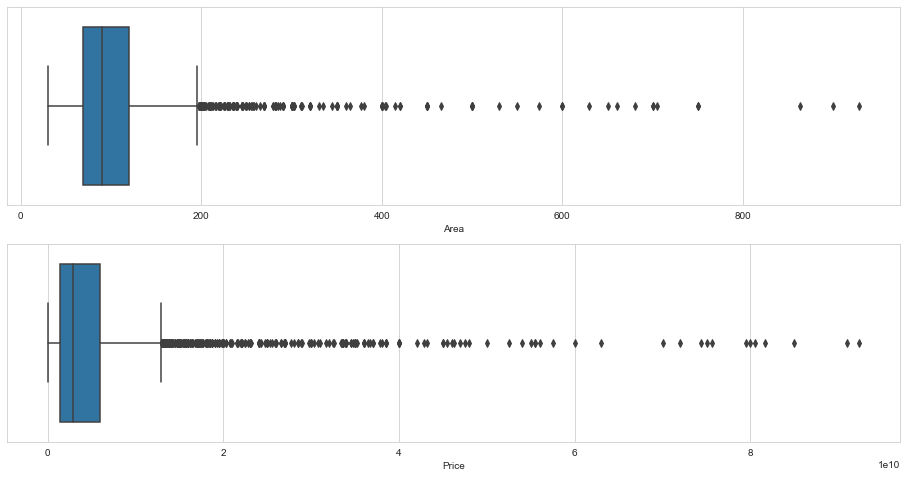

In [9]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = house_price_df['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = house_price_df['Price'])

In [10]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(house_price_df['Area'])
lower_price, upper_price = lower_upper(house_price_df['Price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -7.50
Upper limit for area: 196.50
Lower limit for price: -5,451,875,000.0
Upper limit for price: 12,871,125,000.0


In [11]:
area_outliers = np.where(house_price_df['Area'] > upper_area)
price_outliers = np.where(house_price_df['Price'] > upper_price)
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(house_price_df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(house_price_df.iloc[price_outliers])}")
print(f"Number of outliers: {len(house_price_df.iloc[total_outliers])}")

Number of area outliers: 238
Number of price outliers: 309
Number of outliers: 361


In [12]:
house_price = house_price_df.copy()
house_price.drop(total_outliers, inplace = True)
house_price.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {house_price.shape}")

Shape of new dataset: (3089, 7)


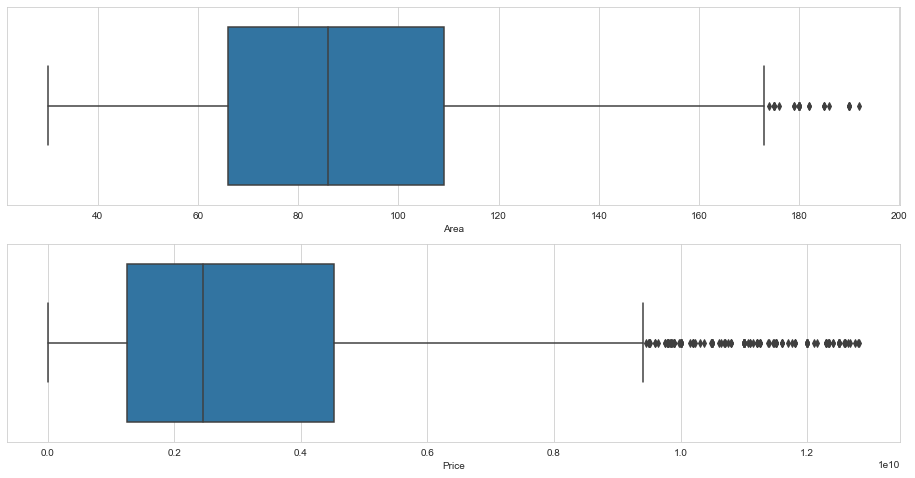

In [13]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = house_price['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = house_price['Price'])

In [14]:
print(f"Skewness of features after drop outliers:\n{house_price.skew()}")

Skewness of features after drop outliers:
Area         0.672756
Room         0.163801
Parking     -1.798618
Warehouse   -2.901748
Elevator    -1.393130
Price        1.285909
dtype: float64


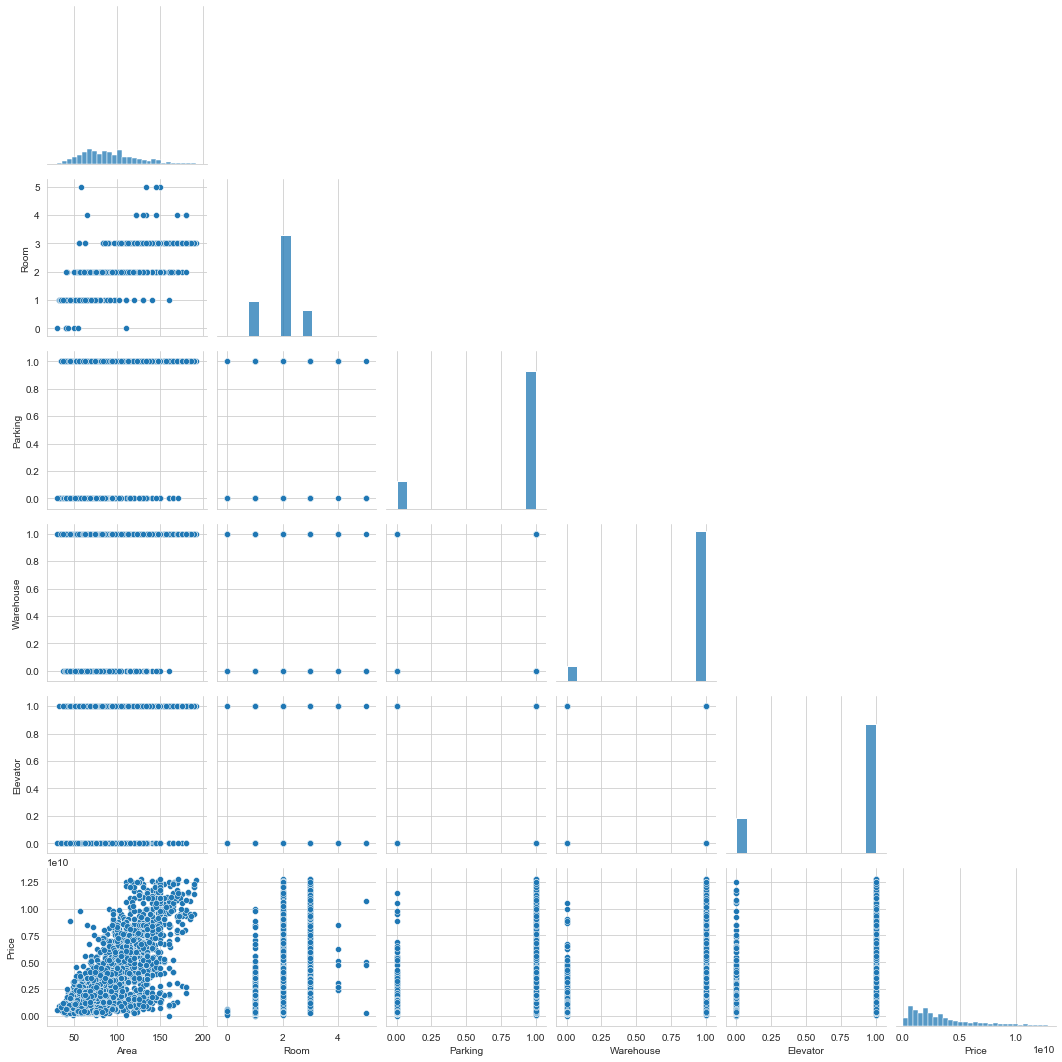

In [15]:
sns.pairplot(house_price, corner = True)

In [16]:
addres_dummy = pd.get_dummies(house_price['Address'])
house_price_final = house_price.merge(addres_dummy, left_index = True, right_index = True)
house_price_final.drop(columns = 'Address', inplace = True)
house_price_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63.0,1,1,1,1,1.850000e+09,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60.0,1,1,1,1,1.850000e+09,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79.0,2,1,1,1,5.500000e+08,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling <a id = "4"></a> 

In [17]:
X = house_price_final.drop(columns = 'Price')
y = house_price_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2471, 192)
shape of y train: (2471,)
shape of x test: (618, 192)
shape of y train: (618,)


In [18]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score = round(grid_fit.score(X_train, y_train), 4) 
    test_score = round(grid_fit.score(X_test, y_test), 4)
    RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"The coefficient of determination (R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"The coefficient of determination (R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

<figure>
    <figcaption>Cost Function for linear regression</figcaption>
    <img src='https://miro.medium.com/max/495/1*v6EnnH1WkXJ01YLcK--qhA.png' />
</figure>

In [19]:
lr = LinearRegression(n_jobs = -1)

lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})

The best parameters for LinearRegression model is: {}
--------------------
The coefficient of determination (R2 score) in the training set is 86.99% for LinearRegression model.
The coefficient of determination (R2 score) in the testing set is 87.12% for LinearRegression model.
RMSE is 990,705,109 for LinearRegression model.
--------------------
Runtime of the program is: 2.62


<figure>
    <figcaption>Cost Function for Ridge regression</figcaption>
    <img src='https://miro.medium.com/max/495/1*v6EnnH1WkXJ01YLcK--qhA.png' />
</figure>

In [20]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_train_score, ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)

The best parameters for Ridge model is: {'alpha': 1}
--------------------
The coefficient of determination (R2 score) in the training set is 86.48% for Ridge model.
The coefficient of determination (R2 score) in the testing set is 86.84% for Ridge model.
RMSE is 1,001,494,793 for Ridge model.
--------------------
Runtime of the program is: 2.69


<figure>
    <figcaption>Cost Function for Lasso regression</figcaption>
    <img src='https://miro.medium.com/max/618/1*MzVvLRrsHNX6txA27U9k-Q.png' />
</figure>

In [21]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_train_score, lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

The best parameters for Lasso model is: {'alpha': 10}
--------------------
The coefficient of determination (R2 score) in the training set is 86.99% for Lasso model.
The coefficient of determination (R2 score) in the testing set is 87.09% for Lasso model.
RMSE is 992,153,348 for Lasso model.
--------------------
Runtime of the program is: 10.96


<figure>
    <figcaption>Cost Function for ElasticNet</figcaption>
    <img src='https://miro.medium.com/max/700/1*5qda942X54E4i9exXF3XmQ.png' />
</figure>

In [22]:
eln = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_train_score, eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

The best parameters for ElasticNet model is: {'alpha': 0.001, 'l1_ratio': 0.7}
--------------------
The coefficient of determination (R2 score) in the training set is 86.65% for ElasticNet model.
The coefficient of determination (R2 score) in the testing set is 86.97% for ElasticNet model.
RMSE is 996,706,469 for ElasticNet model.
--------------------
Runtime of the program is: 4.13


<figure>
    <figcaption>Ordinary regression compares to the Lasso, the Ridge and the Elastic Net Regressors</figcaption>
    <img src='https://miro.medium.com/max/1400/1*nrWncnoJ4V_BkzEf1pd4MA.png' />
</figure>

In [23]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 3}
--------------------
The coefficient of determination (R2 score) in the training set is 97.82% for DecisionTreeRegressor model.
The coefficient of determination (R2 score) in the testing set is 78.12% for DecisionTreeRegressor model.
RMSE is 1,291,465,466 for DecisionTreeRegressor model.
--------------------
Runtime of the program is: 0.85


In [24]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 5}
--------------------
The coefficient of determination (R2 score) in the training set is 95.10% for RandomForestRegressor model.
The coefficient of determination (R2 score) in the testing set is 82.24% for RandomForestRegressor model.
RMSE is 1,163,699,306 for RandomForestRegressor model.
--------------------
Runtime of the program is: 23.83


In [25]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 20, 'weights': 'distance'}
--------------------
The coefficient of determination (R2 score) in the training set is 98.41% for KNeighborsRegressor model.
The coefficient of determination (R2 score) in the testing set is 67.38% for KNeighborsRegressor model.
RMSE is 1,576,865,011 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 2.72


# Conclusions <a id = "5"></a> 

In [26]:
models_score = pd.DataFrame({'Training score': [lr_train_score, ridge_train_score, 
                                                lasso_train_score, eln_train_score,
                                               dtr_train_score, rfr_train_score,
                                               knr_train_score],
                             'Testing score': [lr_test_score, ridge_test_score, 
                                                lasso_test_score, eln_test_score,
                                               dtr_test_score, rfr_test_score,
                                               knr_test_score],
                             'RMSE': [lr_RMSE, ridge_RMSE,
                                      lasso_RMSE, eln_RMSE,
                                      dtr_RMSE, rfr_RMSE,
                                      knr_RMSE],                             
                             },
                           index = ['LinearRegression', 'Ridge', 'Lasso','ElasticNet',
                                    'DecisionTreeRegressor', 'RandomForestRegressor',
                                    'KNeighborsRegressor']
                           )

models_score

,Training score,Testing score,RMSE
LinearRegression,0.8699,0.8712,990705109
Ridge,0.8648,0.8684,1001494793
Lasso,0.8699,0.8709,992153348
ElasticNet,0.8665,0.8697,996706469
DecisionTreeRegressor,0.9782,0.7812,1291465466
RandomForestRegressor,0.9510,0.8224,1163699306
KNeighborsRegressor,0.9841,0.6738,1576865011


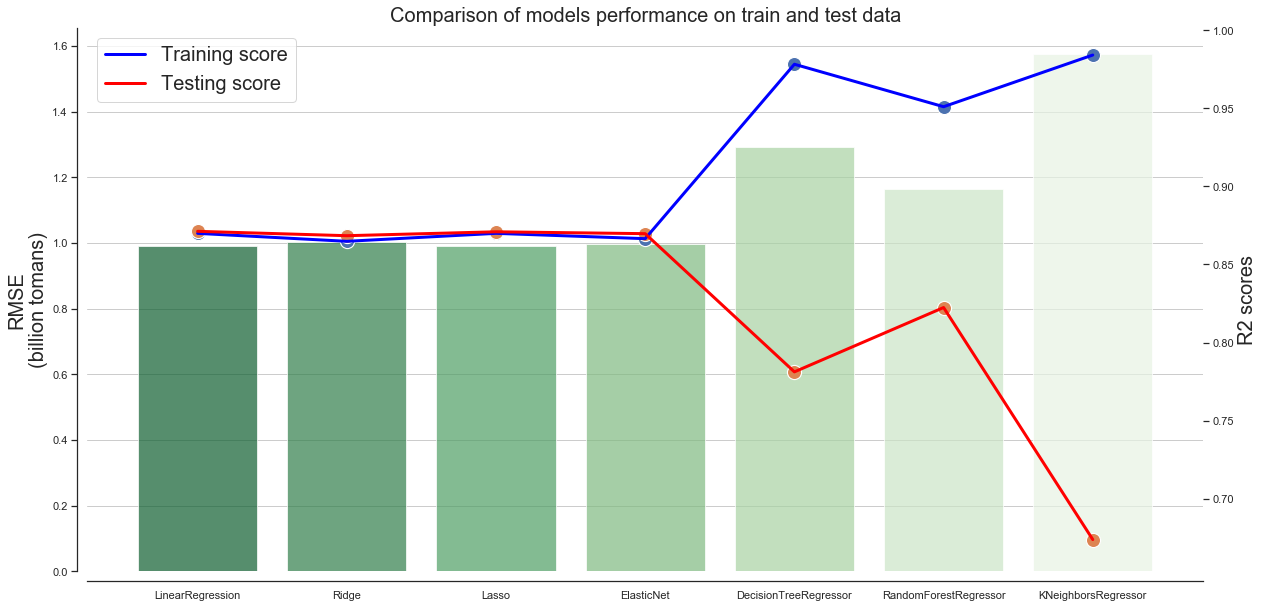

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Comparison of models performance on train and test data", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1000000000, 
                 alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(billion tomans)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Training score'], 
                  linewidth = 3, color = 'blue')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Training score'],
                    s = 200)

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'],
                 linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'],
                    s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = ['Training score', 'Testing score'], fontsize = 20)


sns.despine(offset = 10)

plt.show()

As can be seen from the plot above, **linear regression** has the lowest RMSE and the highest R2 score in the test data.

# References <a id = "6"></a> 

<a href = "https://towardsdatascience.com/from-linear-regression-to-ridge-regression-the-lasso-and-the-elastic-net-4eaecaf5f7e6">From Linear Regression to Ridge Regression, the Lasso, and the Elastic Net</a>